### Extracting Stock Sentiment from News Headlines

## 1. Project Introduction
<p>In this project, I generated investing insight by applying sentiment analysis on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using natural language processing technique, I was able to understand the emotion behind the headlines and predict whether the market feels good or bad about a stock. It would then be possible to make educated guesses on how certain stocks would perform and trade accordingly.</p>

<p> The reasons why I used FINVIZ was because FINVIZ contained a list of trusted websites and headlines from these sites tended to be more consistent in their jargon than those from independent bloggers. In addition, headlines, which have similar length, are easier to parse and group than full articles, which vary in length.
    
<p>As web scraping requires data science ethics (sending a lot of traffic to a FINVIZ's servers isn't very nice), the HTML files for Facebook and Tesla on 28/12/2021 have been downloaded.</p>

In [178]:
# Import libraries
from bs4 import BeautifulSoup
import os
html_tables = {} # Create an empty dictionary
# For every table in the datasets folder
for table_name in os.listdir('datasets'): # os.listdir = ['FB_28122021.html', 'TSLA_28122021.html']
    # This is the path to the file
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r') # table_file is <class '_io.TextIOWrapper'>
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file) #  BeautifulSoup() scrape html of a webpage and save it in a variable html which is not a BeautifulSoup object 
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    # Add the table to our dictionary
    html_tables[table_name] = html_table

## 2.1 Exploring TSLA headline table
I explored TSLA's headline and extracted its date & time as well as its according headlines. 

In [179]:
# Read one single day of TSLA headlines 
tsla = html_tables['TSLA_28122021.html'] 
# Get all the table rows <tr> in the file into 'tesla_tr'
tsla_tr = tsla.findAll('tr') # tsla_tr looks like a list of [<tr></tr>,<tr></tr>,<tr></tr>,...]

# For each row in Tesla's headlines table:
for i, table_row in enumerate(tsla_tr): # i is class int & table_row is class bs4.element.Tag
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text() # header
    # Read the text of the element <td> into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text) # headline 
    print(data_text) # date and time of the headline
    # The following exits the loop after four rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

File number 1:
Dow Jones Futures Rise As Tesla Eyes New Buy Point; 5 Top Stocks To Buy And Watch
Dec-28-21 09:13AM  
File number 2:
3 Stocks That Could Beat the Market in 2022
09:00AM  
File number 3:
Tesla Stock Flashes Buy Signal As Strong Q4 Deliveries Seen
08:45AM  
File number 4:
Why Tesla Stock Is in a Clear Position of Strength Heading Into 2022
08:29AM  


## 2.2 Exploring FB headline table
I explored FB's headline and extracted its date & time as well as its according headlines.

In [180]:
# Read one single day of FB headlines 
fb = html_tables['FB_28122021.html'] 
# Get all the table rows <tr> in the file into 'fb_tr'
fb_tr = fb.findAll('tr') # fb_tr looks like a list of [<tr></tr>,<tr></tr>,<tr></tr>,...]

# For each row in fb's headlines table:
for i, table_row in enumerate(fb_tr): # i is class int & table_row is class bs4.element.Tag
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text() # header
    # Read the text of the element <td> into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text) # headline 
    print(data_text) # date and time of the headline
    # The following exits the loop after four rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

File number 1:
3 Stocks That Could Beat the Market in 2022
Dec-28-21 09:00AM  
File number 2:
The Metaverse Just Got Bigger During the Holidays
08:30AM  
File number 3:
Better Buy: Apple vs. Facebook
08:04AM  
File number 4:
T. Rowe Price U.S. Large-Cap Core Fund, Inc. ...
07:38AM  


## 3. Parsing tickers, dates, times, and headlines

In [181]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items(): 
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() # get text from <tr> tag where text is class string
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split() # x.td.text is the text in <tr> tag; date_scrape looks like this ['Jan-04-19', '06:22PM'] or ['01:52PM']  
        #If the length of 'date_scrape' is 1, load 'time' with the only element
        # If not, load 'date' with the 1st element and 'time' with the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split("_")[0] # split file_name by "_" so FB_28122021.html becomes ['FB', '28122021.html'] >> ticker = FB 
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text]) 

## 4. Making NLTK think like a financial journalist
<p>Sentiment analysis is very sensitive to context. As an example, saying <em>"This is so addictive!"</em> often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. Remember that the reason we chose headlines is so we can try to extract sentiment from financial journalists, who like most professionals, have their own lingo. Therefore, I added some words and according sentiment values to make NLTK think like a financial journalist.</p>

In [182]:
# NLTK VADER for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyser with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)


[nltk_data] Downloading package vader_lexicon to C:\Users\Yuting
[nltk_data]     Huang\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 5. Obtaining polarity scores for every headline from TSLA & FB
Now that I had the data and the algorithm loaded, I used vader.polarity_scores to predict sentiment out of news headlines from TSLA & FB.

In [183]:
import pandas as pd
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns) # columns parameter sets the column names of the dataaframe
# Iterate through the headlines and get the polarity scores of each headline
headlines = [headline for headline in scored_news.headline] # each headline is a string
scores = [vader.polarity_scores(headline) for headline in scored_news.headline] # each headline has one polarity score
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores) # score_df has 4 columns with column names 'neg', 'neu', 'pos' ,'compound' 
scored_news.columns = columns # set up column names for scores_df 
# Join the scored_news and scores_df 
scored_news = scored_news.join(scores_df)
# Convert the date column from string to a date
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

## 6. Plotting all the sentiment in subplots
The below plot shows that TSLA's sentiment on 22-12-2021 was relatively positive, which may be attributed to verbatim. Therefore, I performed some operations to remove duplicates. It is also worth noticing that FB's compound rate is extremely positive on 25-12-2021, which may be due to the small number of FB news released on that day.

ticker            FB      TSLA
date                          
2021-12-21  0.147319       NaN
2021-12-22  0.063300  0.258027
2021-12-23  0.102669  0.155025
2021-12-24 -0.108311 -0.069950
2021-12-25  0.510600  0.000000
2021-12-26  0.077420 -0.067033
2021-12-27  0.157687  0.109554
2021-12-28  0.263440  0.180831


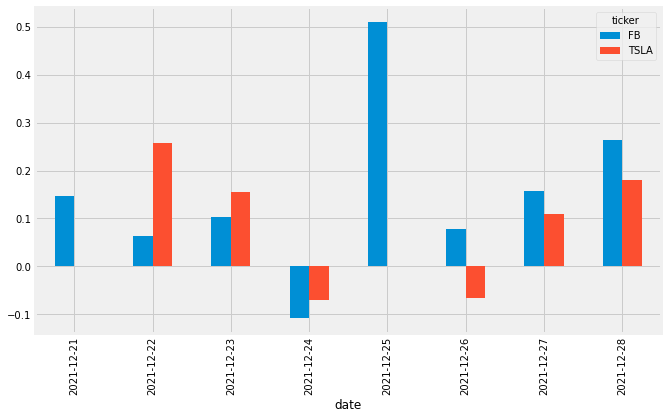

In [184]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") # a graph with certain characteristics
# By using the 'inline' backend, the matplotlib graphs would be included in the notebook, next to the code
%matplotlib inline 
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_unstacked = mean_c.unstack('ticker')
# Get the cross-section of compound in the 'columns' axis
mean_compound = mean_unstacked.xs("compound", axis="columns") # mean_compound is a dataframe
print(mean_compound)
# Plot a bar chart with pandas
mean_compound.plot.bar(figsize = (10, 6));

## 7. Removing duplicate headlines
I removed 4 duplicate headlines and conducted sentiment analysis again and found a slight change in sentiment for FB on 26-12-2021. The compound rate changed from positive to negative after duplicate headlines were removed. 

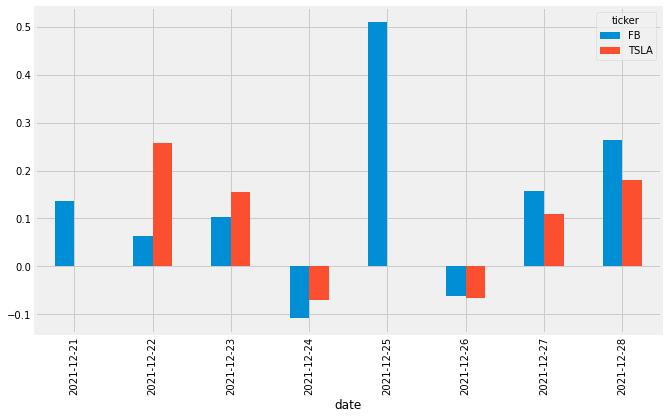

In [185]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker']) # Only consider 'headline' & 'ticker' columns for identifying duplicates
# Count number of headlines after dropping duplicates (store as integer)
num_news_after = scored_news_clean.headline.count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"
# Conduct sentiment analysis again with the cleaned headelines
plt.style.use("fivethirtyeight") # a graph with certain characteristics
# By using the 'inline' backend, the matplotlib graphs would be included in the notebook, next to the code
%matplotlib inline 
# Group by date and ticker columns from scored_news and calculate the mean
mean_cleaned = scored_news_clean.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_cleaned = mean_cleaned.unstack('ticker')
# Get the cross-section of compound in the 'columns' axis
mean_cleaned = mean_cleaned.xs("compound", axis="columns") # mean_compound is a dataframe
# Plot a bar chart with pandas
mean_cleaned.plot.bar(figsize = (10, 6));

## 8.1 Sentiment on one single trading day on TSLA
Sentiment analysis on TSLA on 28-12-2021 was conducted below. 

In [186]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the TSLA row
single_day_tsla = single_day.xs('TSLA')
# Select the 28th of December of 2021
single_day_tsla = single_day_tsla.loc['2021-12-28']
# Convert the datetime string to just the time
single_day_tsla['time'] = pd.to_datetime(single_day_tsla['time']).dt.time
# Set the index to time and sort by it
single_day_tsla = single_day_tsla.set_index('time')
# Sort it
single_day_tsla = single_day_tsla.sort_index()
print(single_day_tsla)

                                                   headline    neg    neu  \
time                                                                        
00:59:00  Tesla, Apple, Boeing, Fauci, Flights And More ...  0.000  0.839   
01:18:00  Tesla Stock Gains As Wedbush Says China Demand...  0.084  0.782   
01:48:00        Tesla Gains as Wedbush Sees Stock at $1,400  0.000  0.745   
02:11:00  15 E-Mobility Stocks That Could Become The New...  0.000  1.000   
03:21:00                          Tesla Has One Big Problem  0.403  0.597   
04:33:00  China Says It Complained to UN About Musks Spa...  0.231  0.769   
06:55:00  Tesla Could Rise 30% Next Year on China Demand...  0.130  0.870   
07:13:00  Tesla in a Clear Position of Strength Heading ...  0.000  0.707   
07:20:00  Dow Jones Futures Rally: Tesla Hits New Buy Po...  0.000  0.886   
08:29:00  Why Tesla Stock Is in a Clear Position of Stre...  0.000  0.633   
08:45:00  Tesla Stock Flashes Buy Signal As Strong Q4 De...  0.000  0.732   

## 8.2 Sentiment on one single trading day on FB
Sentiment analysis on FB on 28-12-2021 was conducted below. 

In [187]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the FB row
single_day_fb = single_day.xs('FB')
# Select the 28th of December of 2021
single_day_fb = single_day_fb.loc['2021-12-28']
# Convert the datetime string to just the time
single_day_fb['time'] = pd.to_datetime(single_day_fb['time']).dt.time
# Set the index to time and sort by it
single_day_fb = single_day_fb.set_index('time')
# Sort it
single_day_fb = single_day_fb.sort_index()
print(single_day_fb)

                                                   headline  neg    neu  \
time                                                                      
00:11:00  Meta Gains as KeyBanc Sees Holidays Boosting O...  0.0  0.486   
02:38:00  Ershares Entrepreneurs Etf Buys Oracle Corp, R...  0.0  1.000   
05:52:00  How You Can Make More Money on the Metaverse T...  0.0  1.000   
06:35:00      3 Things About Wish That Smart Investors Know  0.0  0.481   
06:55:00  Facebook stock could get a big boost from surg...  0.0  0.787   
07:07:00             Could Bumble Become the Next Facebook?  0.0  1.000   
07:38:00   T. Rowe Price U.S. Large-Cap Core Fund, Inc. ...  0.0  1.000   
08:04:00                     Better Buy: Apple vs. Facebook  0.0  0.580   
08:30:00  The Metaverse Just Got Bigger During the Holidays  0.0  0.729   
09:00:00        3 Stocks That Could Beat the Market in 2022  0.0  1.000   

            pos  compound  
time                       
00:11:00  0.514    0.7506  
02:38:00  0.000

## 9.1 Visualising the single day sentiment on TSLA
I then created a plot to visualise the positive, negative and neutral scores for a single day ie. 28-12-2021 of trading TSLA stock.

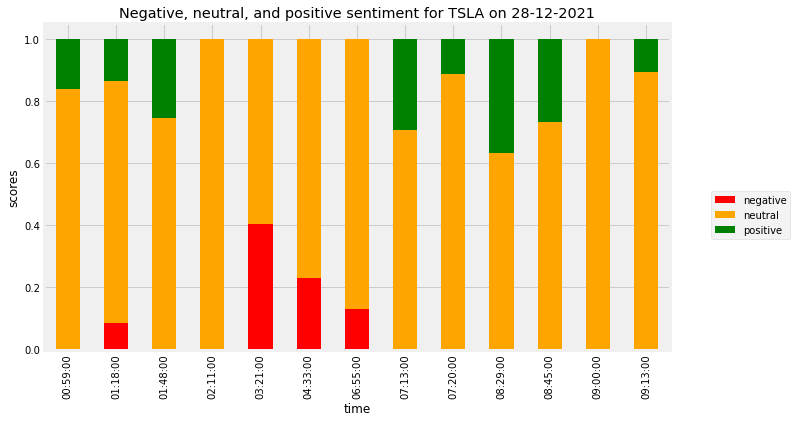

In [188]:
TITLE = "Negative, neutral, and positive sentiment for TSLA on 28-12-2021"
COLORS = ["red","orange", "green"]
# single day is a dataframe
# Drop the columns that aren't useful for the plot; 1 here refers to columns dropped 
plot_day_tsla = single_day_tsla.drop(['compound', 'headline'], 1) 
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day_tsla.columns = ['negative', 'neutral', 'positive'] # original column names are 'neg','neu','pos'
# Plot a stacked bar chart
plot_day_tsla.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");

## 9.2 Visualising the single day sentiment on FB
I then created a plot to visualise the positive, negative and neutral scores for a single day ie. 28-12-2021 of trading FB stock.

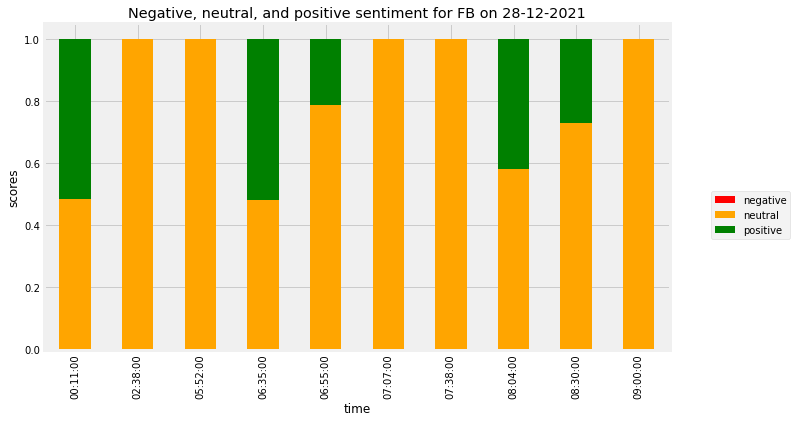

In [189]:
TITLE = "Negative, neutral, and positive sentiment for FB on 28-12-2021"
COLORS = ["red","orange", "green"]
# single day is a dataframe
# Drop the columns that aren't useful for the plot; 1 here refers to columns dropped 
plot_day_fb = single_day_fb.drop(['compound', 'headline'], 1) 
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day_fb.columns = ['negative', 'neutral', 'positive'] # original column names are 'neg','neu','pos'
# Plot a stacked bar chart
plot_day_fb.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");